In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import datetime
import csv
import config
from torch.utils.data import random_split

In [2]:
# --- Dataset ---
class JetbotDataset(Dataset):
    def __init__(self, image_dir, csv_path, image_size, num_prev_frames, transform=None):
        self.image_dir = image_dir
        self.csv_path = csv_path
        self.image_size = image_size
        self.transform = transform
        self.num_prev_frames = num_prev_frames
        self.image_paths, self.actions = self.load_data()
        self.image_paths = self.image_paths[self.num_prev_frames:]
        self.actions = self.actions[self.num_prev_frames:]


    def load_data(self):
        image_paths = []
        actions = []
        with open(self.csv_path, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_paths.append(row['image_path'])
                actions.append(float(row['action']))
        return image_paths, actions

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        current_image_path = self.image_paths[idx]
        current_image = Image.open(current_image_path).convert("RGB")
        current_action = self.actions[idx]

        prev_frames = []
        for i in range(self.num_prev_frames):
            prev_image_path = self.image_paths[idx - (self.num_prev_frames - i)]
            prev_image = Image.open(prev_image_path).convert("RGB")
            if self.transform:
                prev_image = self.transform(prev_image)
            prev_frames.append(prev_image)

        if self.transform:
            current_image = self.transform(current_image)

        prev_frames_tensor = torch.cat(prev_frames, dim=0)

        return current_image, torch.tensor([current_action], dtype=torch.float32), prev_frames_tensor

# --- Diffusion Helpers ---
def linear_beta_schedule(timesteps, beta_start, beta_end):
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, betas, alphas_cumprod, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(torch.sqrt(alphas_cumprod), t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        torch.sqrt(1. - alphas_cumprod), t, x_0.shape
    )
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# --- U-Net Model ---
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUNet(nn.Module):
    def __init__(self, image_channels=3, down_channels=(64, 128, 256), up_channels=(256, 128, 64), time_emb_dim=32, num_prev_frames=4):
        super().__init__()
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(image_channels * (num_prev_frames + 1), down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim + 1) \
                    for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim + 1, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)


    def forward(self, x, timestep, action, prev_frames):
        x = torch.cat([x, prev_frames], dim=1)

        t = self.time_mlp(timestep)
        if action is not None:
            action = action.float()
            if len(action.shape) == 1:
                action = action.unsqueeze(1)
            t = torch.cat([t, action], dim=1)

        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

# --- Training Loop ---
def train(model, dataloader, optimizer, betas, alphas_cumprod, start_epoch, num_epochs,
          device, save_every, sample_every, checkpoint_dir, sample_dir, plot_dir,
          plot_every, use_fp16, accumulation_steps, num_prev_frames,
          early_stopping_patience=5, early_stopping_percentage=0.1, min_epochs=5):
    """
    Trains the diffusion model with early stopping and best model saving/deletion.
    """

    all_losses = []
    start_time = time.time()
    last_plot_epoch = 0
    best_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0
    moving_avg_window = 10
    moving_avg_losses = []
    previous_best_model_path = None  # Keep track of the previous best model's path

    scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_losses = []
        optimizer.zero_grad()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for step, (images, actions, prev_frames) in enumerate(pbar):
            images = images.to(device)
            actions = actions.to(device)
            prev_frames = prev_frames.to(device)
            t = torch.randint(0, config.NUM_TIMESTEPS, (images.shape[0],), device=device).long()

            with torch.cuda.amp.autocast(enabled=use_fp16):
                x_noisy, noise = forward_diffusion_sample(images, t, betas, alphas_cumprod, device)
                predicted_noise = model(x_noisy, t, actions, prev_frames)
                loss = F.mse_loss(noise, predicted_noise)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_losses.append(loss.item() * accumulation_steps)
            pbar.set_postfix({"Loss": loss.item() * accumulation_steps})

        if optimizer.param_groups[0]['params'][0].grad is not None:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        all_losses.append(avg_epoch_loss)

        moving_avg_losses.append(avg_epoch_loss)
        if len(moving_avg_losses) > moving_avg_window:
            moving_avg_losses.pop(0)
        current_moving_avg = sum(moving_avg_losses) / len(moving_avg_losses)

        if (epoch + 1) % save_every == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss,
            }, os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth"))
            print(f"Saved model checkpoint at epoch {epoch+1}")

        if (epoch + 1) % sample_every == 0:
            model.eval()
            with torch.no_grad():
                random_idx = torch.randint(0, len(dataset), (1,)).item()
                real_current_frame, action, real_prev_frames = dataset[random_idx]
                real_current_frame = real_current_frame.unsqueeze(0).to(device)
                real_prev_frames = real_prev_frames.unsqueeze(0).to(device)
                action = action.to(device)

                t_sample = torch.tensor([config.NUM_TIMESTEPS - 1], device=device, dtype=torch.long)
                x_noisy, _ = forward_diffusion_sample(real_current_frame, t_sample, betas, alphas_cumprod, device)
                x = x_noisy

                for i in reversed(range(1, config.NUM_TIMESTEPS)):
                    t = (torch.ones(1) * i).long().to(device)
                    with torch.cuda.amp.autocast(enabled=use_fp16):
                        predicted_noise = model(x, t, action, real_prev_frames)

                    alpha = alphas[t][:, None, None, None]
                    alpha_hat = alphas_cumprod[t][:, None, None, None]
                    beta = betas[t][:, None, None, None]

                    if i > 1:
                        noise = torch.randn_like(x)
                    else:
                        noise = torch.zeros_like(x)
                    x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                predicted_next_frame = (x.clamp(-1, 1) + 1) / 2
                predicted_next_frame = (predicted_next_frame * 255).type(torch.uint8)
                prev_images = []

                for i in range(num_prev_frames):
                    frame = real_prev_frames[0, (i * 3):(i + 1) * 3, :, :]
                    frame = (frame.clamp(-1, 1) + 1) / 2
                    frame = (frame * 255).type(torch.uint8)
                    prev_images.append(transforms.ToPILImage()(frame))

                current_image = transforms.ToPILImage()((real_current_frame[0].clamp(-1, 1) + 1) / 2 * 255).convert("RGB") #Fixed
                predicted_image = transforms.ToPILImage()(predicted_next_frame[0]).convert("RGB")

                total_width = (num_prev_frames + 2) * config.IMAGE_SIZE
                max_height = config.IMAGE_SIZE
                new_im = Image.new('RGB', (total_width, max_height))

                x_offset = 0
                for image in prev_images:
                    new_im.paste(image, (x_offset,0))
                    x_offset += config.IMAGE_SIZE
                new_im.paste(current_image, (x_offset, 0))
                x_offset += config.IMAGE_SIZE
                new_im.paste(predicted_image, (x_offset, 0))

                new_im.save(os.path.join(sample_dir, f"sample_epoch_{epoch+1}.png"))
                print(f"Saved sample image at epoch {epoch+1}")

            model.train()

        if (epoch + 1) % plot_every == 0:
            elapsed_time = time.time() - start_time
            formatted_time = str(datetime.timedelta(seconds=elapsed_time))

            fig, axes = plt.subplots(1, 2, figsize=(16, 5))

            axes[0].plot(all_losses)
            axes[0].set_xlabel("Epoch")
            axes[0].set_ylabel("Loss")
            axes[0].set_title(f"Training Loss from Start (Time: {formatted_time})")
            axes[0].grid(True)

            axes[1].plot(range(last_plot_epoch + 1, epoch + 2), all_losses[last_plot_epoch:])
            axes[1].set_xlabel("Epoch")
            axes[1].set_ylabel("Loss")
            axes[1].set_title(f"Loss Since Last Plot (Epoch {last_plot_epoch + 1})")
            axes[1].grid(True)

            plt.tight_layout()
            plt.savefig(os.path.join(plot_dir, f"loss_plot_epoch_{epoch+1}.png"))
            plt.close()
            print(f"Epoch {epoch+1}: Loss = {avg_epoch_loss:.4f}, Time = {formatted_time}")

            last_plot_epoch = epoch

        # --- Early Stopping (Dynamic Threshold) and Best Model Saving/Deletion---
        if early_stopping_patience is not None and epoch + 1 > min_epochs:
            if current_moving_avg < best_loss:
                best_loss = current_moving_avg
                best_epoch = epoch + 1
                epochs_without_improvement = 0

                # Save the *best* model
                new_best_model_path = os.path.join(checkpoint_dir, f"model_best_epoch_{best_epoch}.pth")
                torch.save({
                    'epoch': best_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_loss,  # Save the best loss
                }, new_best_model_path)
                print(f"Saved best model at epoch {best_epoch} with loss {best_loss}")

                # Delete the *previous* best model (if it exists)
                if previous_best_model_path and os.path.exists(previous_best_model_path):
                    os.remove(previous_best_model_path)
                    print(f"Deleted previous best model: {previous_best_model_path}")
                previous_best_model_path = new_best_model_path # Update the path

            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= early_stopping_patience:
                if len(moving_avg_losses) == moving_avg_window:
                    prev_moving_avg = sum(moving_avg_losses[:-1]) / (moving_avg_window - 1)
                    improvement = (prev_moving_avg - current_moving_avg) / prev_moving_avg * 100
                if improvement < early_stopping_percentage:
                    print(f"Early stopping triggered at epoch {epoch+1}.  Improvement: {improvement:.2f}%")
                    break

    end_time = time.time()
    total_time = end_time - start_time
    formatted_time = str(datetime.timedelta(seconds=total_time))
    print(f"Total training time: {formatted_time}")

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_epoch_loss,
    }, os.path.join(checkpoint_dir, "model_last.pth"))
    print(f"Saved last model at epoch {epoch+1} with loss {avg_epoch_loss}")

    return all_losses

def save_existing_split(train_dataset, test_dataset, filename="dataset_split.pth"):
    """Saves the indices of existing Subset objects to a file.

    Args:
        train_dataset: The Subset object representing the training set.
        test_dataset: The Subset object representing the test set.
        filename: The name of the file to save the indices to.
    """

    # Check if they are actually Subset objects.  Important!
    if not isinstance(train_dataset, Subset) or not isinstance(test_dataset, Subset):
        raise TypeError("Both train_dataset and test_dataset must be Subset objects.")

    # Extract the indices. This is the key step.
    train_indices = train_dataset.indices
    test_indices = test_dataset.indices

    # Combine them into a single list (or tuple) for saving.
    all_indices = [train_indices, test_indices]

    # Save the indices using torch.save
    torch.save(all_indices, os.path.join(config.OUTPUT_DIR, filename))

def load_train_test_split(dataset, filename="dataset_split.pth"):
    """Loads the indices of existing Subset objects from a file."""

    filepath = os.path.join(config.OUTPUT_DIR, filename)
    if not os.path.exists(filepath):
        return None, None # Return None if file does not exist

    splits = torch.load(filepath)
    return tuple(Subset(dataset, indices) for indices in splits)
    

In [4]:
# --- Data Transforms ---
transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Create Dataset and DataLoader ---
dataset = JetbotDataset(config.IMAGE_DIR, config.CSV_PATH, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=transform)

# Try to load existing split
train_dataset, test_dataset = load_train_test_split(dataset, config.SPLIT_DATASET_FILENAME)

if train_dataset is None or test_dataset is None:
    print("Dataset split file not found, creating a new split...")
    train_size = int(0.8 * len(dataset))  # 80% for training
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    save_existing_split(train_dataset, test_dataset, config.SPLIT_DATASET_FILENAME)
else:
    print("Loaded existing dataset split.")

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Batch size 1 for easier evaluation

# --- Calculate Betas and Alphas ---
betas = linear_beta_schedule(config.NUM_TIMESTEPS, config.BETA_START, config.BETA_END).to(config.DEVICE)
#betas = cosine_beta_schedule(NUM_TIMESTEPS).to(DEVICE) # Alternative

alphas = (1. - betas).to(config.DEVICE)
alphas_cumprod = torch.cumprod(alphas, axis=0).to(config.DEVICE)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0).to(config.DEVICE)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(config.DEVICE)

# --- Create Model and Optimizer ---
model = SimpleUNet(image_channels=3, down_channels=(64, 128, 256), up_channels=(256, 128, 64), time_emb_dim=32, num_prev_frames=config.NUM_PREV_FRAMES).to(config.DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

# --- Load Checkpoint (if available) ---
if config.LOAD_CHECKPOINT:
    checkpoint = torch.load(config.LOAD_CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    START_EPOCH = checkpoint['epoch']
    print(f"Loaded checkpoint from epoch {START_EPOCH}")
else:
    START_EPOCH = 0

# --- Train the Model ---
losses = train(model, train_dataloader, optimizer, betas, alphas_cumprod, START_EPOCH, config.NUM_EPOCHS, config.DEVICE,
               config.SAVE_MODEL_EVERY, config.SAMPLE_EVERY, config.CHECKPOINT_DIR, config.SAMPLE_DIR, config.PLOT_DIR, config.PLOT_EVERY, config.USE_FP16,
               config.ACCUMULATION_STEPS, config.NUM_PREV_FRAMES)
print("Training complete!")

# --- Final Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.savefig(os.path.join(config.PLOT_DIR, "loss_plot_final.png"))  # Save to plot dir
plt.close()

Epoch 1/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 2/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 3/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 4/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 5/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 6/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 7/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 8/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 9/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 10/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 11/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 11


Epoch 12/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 12
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_11.pth


Epoch 13/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 13
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_12.pth


Epoch 14/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 14
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_13.pth


Epoch 15/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 15
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_14.pth


Epoch 16/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 16
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_15.pth


Epoch 17/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 17
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_16.pth


Epoch 18/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 18
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_17.pth


Epoch 19/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 19
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_18.pth


Epoch 20/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 20
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_19.pth


Epoch 21/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 21
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_20.pth


Epoch 22/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 22
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_21.pth


Epoch 23/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 23
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_22.pth


Epoch 24/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 24
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_23.pth


Epoch 25/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 25
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_24.pth


Epoch 26/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 26
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_25.pth


Epoch 27/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 27
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_26.pth


Epoch 28/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 28
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_27.pth


Epoch 29/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 29
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_28.pth


Epoch 30/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 30
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_29.pth


Epoch 31/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 31
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_30.pth


Epoch 32/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 32
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_31.pth


Epoch 33/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 33
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_32.pth


Epoch 34/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 34
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_33.pth


Epoch 35/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 35
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_34.pth


Epoch 36/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 36
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_35.pth


Epoch 37/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 37
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_36.pth


Epoch 38/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 38
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_37.pth


Epoch 39/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 39
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_38.pth


Epoch 40/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 40
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_39.pth


Epoch 41/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 41
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_40.pth


Epoch 42/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 42
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_41.pth


Epoch 43/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 43
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_42.pth


Epoch 44/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 44
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_43.pth


Epoch 45/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 46/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 47/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 48/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 49/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 50/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 51/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 52/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 53/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 54/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 55/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 56/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 56
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_44.pth


Epoch 57/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 57
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_56.pth


Epoch 58/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 58
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_57.pth


Epoch 59/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 59
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_58.pth


Epoch 60/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 60
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_59.pth


Epoch 61/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 61
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_60.pth


Epoch 62/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 62
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_61.pth


Epoch 63/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 64/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 65/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 65
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_62.pth


Epoch 66/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 66
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_65.pth


Epoch 67/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 67
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_66.pth


Epoch 68/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 68
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_67.pth


Epoch 69/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 69
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_68.pth


Epoch 70/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 70
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_69.pth


Epoch 71/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 71
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_70.pth


Epoch 72/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 73/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 73
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_71.pth


Epoch 74/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 74
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_73.pth


Epoch 75/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 76/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 77/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 78/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 79/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 80/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 80
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_74.pth


Epoch 81/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 81
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_80.pth


Epoch 82/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 83/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 84/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 85/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 85
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_81.pth


Epoch 86/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 86
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_85.pth


Epoch 87/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 87
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_86.pth


Epoch 88/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 88
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_87.pth


Epoch 89/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 89
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_88.pth


Epoch 90/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 90
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_89.pth


Epoch 91/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 91
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_90.pth


Epoch 92/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 92
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_91.pth


Epoch 93/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 94/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 94
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_92.pth


Epoch 95/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 96/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 97/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 98/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 99/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 100/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved sample image at epoch 100
Epoch 100: Loss = 0.0059, Time = 0:44:38.439659


Epoch 101/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 101
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_94.pth


Epoch 102/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 103/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 103
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_101.pth


Epoch 104/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 104
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_103.pth


Epoch 105/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 105
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_104.pth


Epoch 106/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 106
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_105.pth


Epoch 107/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 107
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_106.pth


Epoch 108/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 109/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 109
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_107.pth


Epoch 110/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 111/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 112/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 112
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_109.pth


Epoch 113/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 113
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_112.pth


Epoch 114/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 114
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_113.pth


Epoch 115/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 116/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 116
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_114.pth


Epoch 117/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 117
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_116.pth


Epoch 118/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 118
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_117.pth


Epoch 119/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 119
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_118.pth


Epoch 120/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 120
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_119.pth


Epoch 121/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 121
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_120.pth


Epoch 122/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 123/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 124/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 125/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 126/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 127/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 128/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 129/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 130/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 131/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 132/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 133/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 134/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 134
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_121.pth


Epoch 135/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 135
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_134.pth


Epoch 136/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 136
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_135.pth


Epoch 137/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 137
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_136.pth


Epoch 138/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 138
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_137.pth


Epoch 139/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 139
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_138.pth


Epoch 140/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 140
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_139.pth


Epoch 141/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 142/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 143/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 144/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 145/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 146/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 147/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 148/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 149/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 150/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 150
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_140.pth


Epoch 151/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 151
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_150.pth


Epoch 152/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 152
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_151.pth


Epoch 153/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 153
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_152.pth


Epoch 154/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 154
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_153.pth


Epoch 155/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 155
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_154.pth


Epoch 156/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 156
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_155.pth


Epoch 157/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Saved best model at epoch 157
Deleted previous best model: output_two_action_224_early_stoppage\checkpoints\model_best_epoch_156.pth


Epoch 158/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 159/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 160/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 161/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 162/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 163/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 164/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 165/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 166/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 167/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 168/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 169/10000:   0%|          | 0/416 [00:00<?, ?it/s]

Early stopping triggered at epoch 169.  Improvement: -1.62%
Total training time: 1:15:08.482388
Saved last model at epoch 169
Training complete!


In [9]:
save_existing_split(train_dataset, test_dataset)

In [13]:
loaded_train, loaded_test = load_train_test_split(dataset)

In [21]:
loaded_test.indices[:20] == test_dataset.indices[:20]

True

In [7]:
config.SAMPLE_EVERY

20

In [44]:
transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = JetbotDataset(config.IMAGE_DIR, config.CSV_PATH, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=transform)

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [23]:
def display_dataset_entry(dataset_entry):
    frame,action,previous_frames = dataset_entry
    print(f'Action: {action}')
    display_frame(frame)
    for i in range(config.NUM_PREV_FRAMES):
        frame = previous_frames[(i * 3):(i + 1) * 3, :, :]  # Extract each frame (C, H, W)
        display_frame(frame)


def display_frame(frame):
    frame = (frame.clamp(-1, 1) + 1) / 2 # Unnormalize
    frame = (frame * 255).type(torch.uint8) # To uint8
    display(transforms.ToPILImage()(frame))


In [50]:
len(test_dataset)

416

Action: tensor([0.])


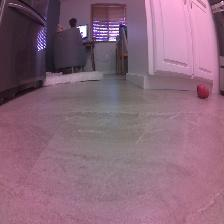

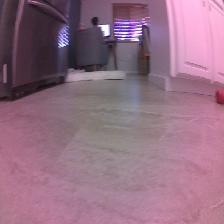

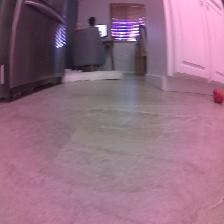

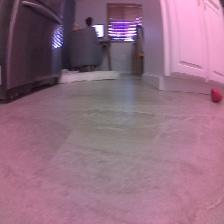

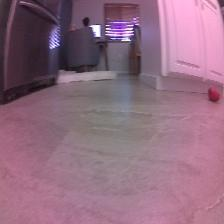

In [24]:
#display_dataset_entry(train_dataset[1201])
display_dataset_entry(test_dataset[401])

Action: tensor([0.])


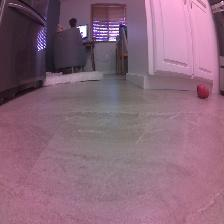

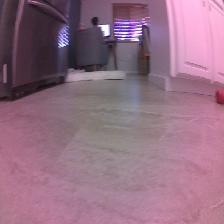

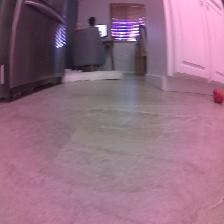

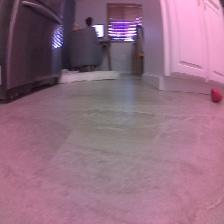

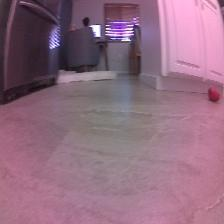

In [26]:
display_dataset_entry(loaded_test[401])

In [25]:
dataset[25][2].shape

torch.Size([12, 224, 224])

In [4]:
test_dataset